In [2]:
# !pip install transformers

# Dataset exploration

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

In [2]:
def converter(item):
    if item == '-':
        return -1
    return int(item)

data = pd.read_csv('translated_data.csv', index_col=0, converters={
    'service': converter, 
    'flavour': converter,
    'speed': converter
})

In [3]:
data

,speed,service,flavour,review
0,-1,1,1,"As I always order from the neighboring bakery,..."
1,-1,10,2,Can you send something with cheese to the man ...
2,-1,10,10,Thank you very much to your teammate who broug...
3,1,1,7,"After waiting more than one hour, they didn't ..."
4,4,4,1,"Although I told it to cook well, it came under..."
...,...,...,...,...
60237,10,10,10,Super.
60238,10,10,10,You are perfect.
60239,10,10,10,Be sure to try the legendary soup.
60240,10,10,10,You are awesome!


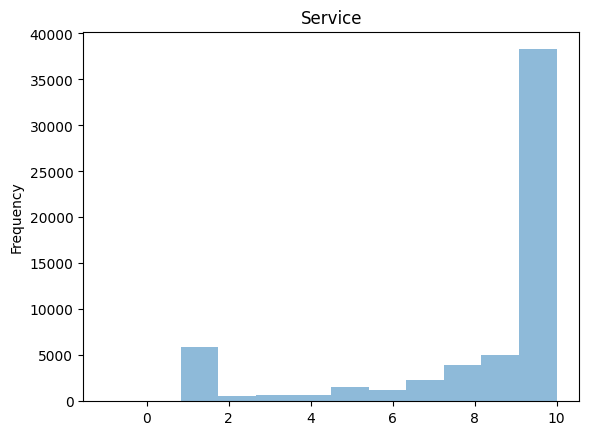

In [4]:
ax = data['service'].plot.hist(bins=12, alpha=0.5)
ax = ax.set_title('Service')

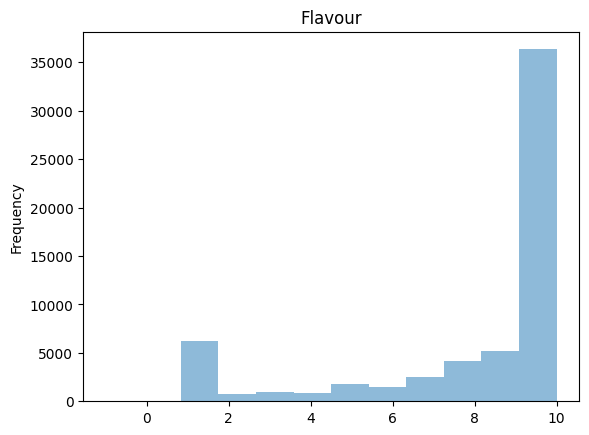

In [5]:
ax = data['flavour'].plot.hist(bins=12, alpha=0.5)
ax = ax.set_title('Flavour')

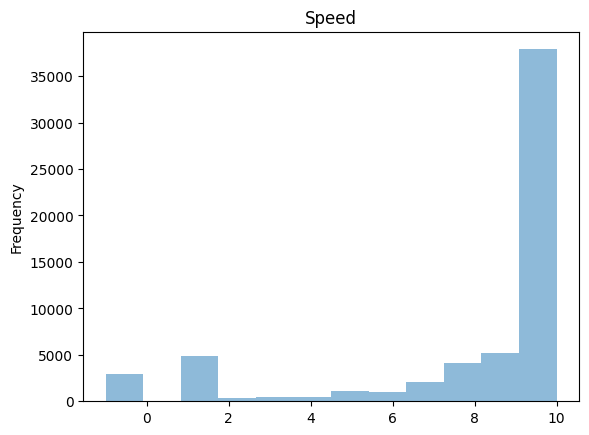

In [6]:
ax = data['speed'].plot.hist(bins=12, alpha=0.5)
ax = ax.set_title('Speed')

In [8]:
columns = ['speed', 'service', 'flavour']
data[columns].corr()

,speed,service,flavour
speed,1.000000,0.594127,0.562782
service,0.594127,1.000000,0.827189
flavour,0.562782,0.827189,1.000000


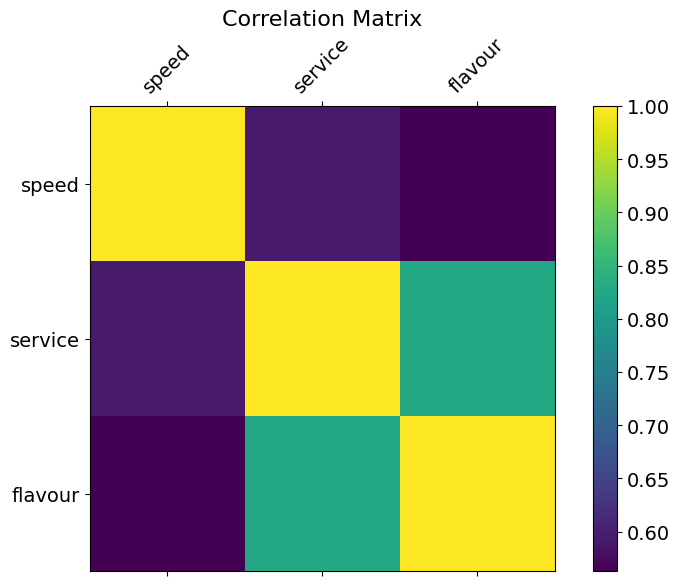

In [9]:
f = plt.figure(figsize=(10, 6))
plt.matshow(data[columns].corr(), fignum=f.number)
plt.xticks(range(len(columns)), columns, fontsize=14, rotation=45)
plt.yticks(range(len(columns)), columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

As we can see we have a big correlation between service and flavour ~0.83 and smaller correlation between speed and others ~0.6. This fact makes sense for our analysis. We can try to extract three different predictions from one text.

In [10]:
invalid_rows = []
for i, row in enumerate(data.iterrows()):
    if row[1][0] == -1 or row[1][1] == -1 or row[1][2] == -1:
        invalid_rows.append(i)
print(len(invalid_rows))

2918


We have some rows without speed rating, for checking our hypothesis it's ok to drop them.

In [11]:
filtered_data = data.drop(invalid_rows)
filtered_data.head()

,speed,service,flavour,review
3,1,1,7,"After waiting more than one hour, they didn't ..."
4,4,4,1,"Although I told it to cook well, it came under..."
5,1,1,1,"It's a shame you brought a stinky hamburger, i..."
6,10,10,10,They bring every food with care and the taste ...
7,1,1,1,"God forgive me, it was very bad, nothing will ..."


Let's take a look on data with '-' in the ratings. I guess there is no connection between '-' in the review and the text of it. So we will use such data for test.

In [12]:
data.values[invalid_rows][:5]

array([[-1, 1, 1,
        "As I always order from the neighboring bakery, I found that it was sent incomplete. Old neighbor bakery service mentality where 2 pieces of cherry cookies sent without notice to complete can't be apologized."],
       [-1, 10, 2,
        "Can you send something with cheese to the man who wants a hot dog? They changed it and sent it. If you don't have it, call and tell, it's ridiculous.."],
       [-1, 10, 10,
        'Thank you very much to your teammate who brought my order very quickly.'],
       [-1, 10, 10, 'Nice meal.'],
       [-1, 1, 1,
        "Is it a wet hamburger without sauce? It's a disgrace. Also, the patso was very bad, the bread separated, a very bad ketchup. I couldn't put the patch."]],
      dtype=object)

In [13]:
from transformers import AutoTokenizer, AutoModel

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [15]:
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [96]:
inputs = tokenizer(["what is i am!", "hio d"], return_tensors="pt", padding=True)
inputs

{'input_ids': tensor([[ 101, 2054, 2003, 1045, 2572,  999,  102],
        [ 101, 7632, 2080, 1040,  102,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0]])}

In [48]:
outputs = model(**inputs)


In [87]:
outputs.pooler_output.shape

torch.Size([1, 768])

Conclusions:
* Ratings are very imbalanced, our naive approach that it is okay for our NN
* There is a positive correlaction between different types of rating, but not close to 1, so it makes sense to solve these problems
* Some [researches](https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df) show that for rating prediction task it's better to setup classification task. We will try two approaches

# Dataset & Dataloader


In [18]:
import torch

In [19]:
import math

def split_dataset(length, fractions):
    lens = []
    for frac in fractions:
        lens.append(math.floor(length * frac))
    lens[-1] += length - sum(lens)
    return lens

In [34]:
train_data, val_data, test_data = torch.utils.data.random_split(
    filtered_data.values, split_dataset(len(filtered_data), [0.8, 0.1, 0.1])
)

In [35]:
from enum import Enum

class RatingType(Enum):
    speed = 0
    service = 1
    flavour = 2

In [68]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.text_data = tokenizer(list(self.data[:][:,3]), padding="max_length", truncation=True, return_tensors="pt")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):        
        return {
            'labels': [self.data[index][:3]],
            'input_ids': self.text_data[index].ids
        }

In [69]:
train_dataset = ReviewDataset(train_data)
val_dataset = ReviewDataset(val_data)
test_dataset = ReviewDataset(test_data)

In [134]:
# Some funny reviews :)
train_dataset[5]

("It's both beautiful and plentiful, well done. But I said big ayran, you sent a small one, please pay attention a little.",
 (10, 1, 9))

In [138]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline
As a baseline we use prediction as average rating

In [75]:
import numpy as np

speed_mse, service_mse, flavour_mse = [], [], []

for sample in test_dataset:
    average = np.mean(sample["labels"])
    speed, service, flavour = sample["labels"][0]
    speed_mse.append((average - speed) ** 2)
    service_mse.append((average - service) ** 2)
    flavour_mse.append((average - flavour) ** 2)

print("Speed baseline:", np.mean(speed_mse))
print("Service baseline:", np.mean(service_mse))
print("Flavour baseline:", np.mean(flavour_mse))

Speed baseline: 1.3963990154466344
Service baseline: 0.9383491288253192
Flavour baseline: 1.2908114812876719


# Model definition

RMSE - target metric

We will choose MAE/MSE as a target loss function for regression
NLL for classification

* [Rating Prediction from Review Text with Regularization — Linear Regression vs Logistic Regression
](https://medium.com/mlearning-ai/rating-prediction-from-review-text-with-regularization-linear-regression-vs-logistic-regression-df0181fe9c07) TLDR; Classification is better for rating prediction than rating
* https://medium.com/data-science-lab-spring-2021/amazon-review-rating-prediction-with-nlp-28a4acdd4352
* https://towardsdatascience.com/review-rating-prediction-a-combined-approach-538c617c495c


Pretrained bert:
https://chtalhaanwar.medium.com/measure-sentence-similarity-using-the-pre-trained-bert-model-eeaf20bc1933

In [77]:
import torch
from torch import nn

In [215]:
class SubRatingModel(nn.Module):
    RATING_CLASSES = 11 # 0 .. 10

    def __init__(self, rating_type):
        super().__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased") # 768 out
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.linear1 = nn.Linear(769, 256) # with average rating
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.linear2 = nn.Linear(256, SubRatingModel.RATING_CLASSES) # with average rating
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.rating_type = rating_type

    def forward(self, inputs):
        target_rating = inputs['labels'][0][self.rating_type.value]
        
        input_ids = torch.tensor(inputs['input_ids']).reshape(1, -1).to(device)
        aggregated_rating = torch.tensor([np.mean(inputs['labels'])],  dtype=torch.float).reshape(1, -1).to(device)
        out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)
        out = torch.cat([out, aggregated_rating], dim=1).flatten()
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        return out
    
    def predict(self, inputs):
        out = self(inputs).detach().cpu().numpy()
        return np.argmax(out)

In [209]:
assert torch.cuda.is_available(), 'there is no cuda here!'
device = 'cuda:2'

In [227]:
from torch.optim import Adam
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()

def fit_model(model, train_dataset, val_dataset, n_epochs=10):
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(n_epochs):
        model.train()
        print(f"epoch #{epoch}")
        history_loss = []
        for sample in tqdm(train_dataset):
            target = torch.tensor([sample['labels'][0][model.rating_type.value]]).to(device)
            optimizer.zero_grad()
            pred = model(sample).reshape(1, -1)
            loss = criterion(pred, target)

            loss.backward()
            history_loss.append(loss.detach().cpu())
            optimizer.step()
        print(f"average loss: {np.mean(history_loss)}")
        
        model.eval()
        history_mse = []
        for sample in tqdm(val_dataset):
            target = torch.tensor([sample['labels'][0][model.rating_type.value]])
            history_mse.append((model.predict(sample) - target.detach().cpu().numpy()) ** 2)
        print(f"average mse: {np.mean(history_mse)}")

In [228]:
service_model = SubRatingModel(RatingType.service).to(device)
fit_model(service_model, train_dataset, val_dataset, n_epochs=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch #0


  0%|          | 0/45859 [00:00<?, ?it/s]

/tmp/ipykernel_1724326/3213269177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)


average loss: 1.1558653116226196


  0%|          | 0/5732 [00:00<?, ?it/s]

average mse: 4.25523377529658
epoch #1


  0%|          | 0/45859 [00:00<?, ?it/s]

In [229]:
def test(model, test_dataset):
    model.eval()
    history_mse = []
    for sample in tqdm(test_dataset):
        target = torch.tensor([sample['labels'][0][model.rating_type.value]])
        history_mse.append((model.predict(sample) - target.detach().cpu().numpy()) ** 2)
    return np.mean(history_mse)

In [231]:
test(service_model, test_dataset)

  0%|          | 0/5733 [00:00<?, ?it/s]

/tmp/ipykernel_1724326/3213269177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)


6.358451072736787

In [232]:
speed_model = SubRatingModel(RatingType.speed).to(device)
fit_model(speed_model, train_dataset, val_dataset, n_epochs=3)
test(speed_model, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch #0


  0%|          | 0/45859 [00:00<?, ?it/s]

/tmp/ipykernel_1724326/3213269177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)


average loss: 1.1679942607879639


  0%|          | 0/5732 [00:00<?, ?it/s]

average mse: 8.492498255408234
epoch #1


  0%|          | 0/45859 [00:00<?, ?it/s]

average loss: 1.0913149118423462


  0%|          | 0/5732 [00:00<?, ?it/s]

average mse: 3.1200279134682485
epoch #2


  0%|          | 0/45859 [00:00<?, ?it/s]

average loss: 1.0579140186309814


  0%|          | 0/5732 [00:00<?, ?it/s]

average mse: 1.904745289602233


  0%|          | 0/5733 [00:00<?, ?it/s]

1.9051107622536194

In [ ]:
flavour_model = SubRatingModel(RatingType.flavour).to(device)
fit_model(flavour_model, train_dataset, val_dataset, n_epochs=3)
test(flavour_model, test_dataset)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch #0


  0%|          | 0/45859 [00:00<?, ?it/s]

/tmp/ipykernel_1724326/3213269177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)


In [234]:
test(flavour_model, test_dataset)

  0%|          | 0/5733 [00:00<?, ?it/s]

/tmp/ipykernel_1724326/3213269177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(self.model(input_ids).pooler_output,  dtype=torch.float).to(device)


10.388976103261818